In [ ]:
import re
import pandas as pd
from time import time
from collections import defaultdict
import spacy
import logging

In [ ]:
logging.basicConfig(format='%(levelname)s - %(asctime)s: %(message)s', datefmt='%H:%M:%S', level=logging.INFO)

In [ ]:
cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
df = pd.read_csv('./simpsons_dataset.csv')
df.shape

(158314, 2)

In [ ]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

INFO - 18:35:14: NumExpr defaulting to 2 threads.


raw_character_text    0
spoken_words          0
dtype: int64

In [ ]:
nlp = spacy.load('en', disable=['ner', 'parser'])

def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
brief_cleaning = (re.sub("[^A-Za-z]+", ' ', str(row)).lower() for row in df['spoken_words'])

In [ ]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {}mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.0mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(92173, 1)

In [ ]:
from gensim.models.phrases import Phrases, Phraser

INFO - 18:36:15: 'pattern' package not found; tag filters are not available for English


In [ ]:
sent = [row.split() for row in df_clean['clean']]

In [ ]:
phrases = Phrases(sent,min_count=30, progress_per=10000)

INFO - 18:36:15: collecting all words and their counts
INFO - 18:36:15: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 18:36:15: PROGRESS: at sentence #10000, processed 67820 words and 51066 word types
INFO - 18:36:15: PROGRESS: at sentence #20000, processed 141206 words and 96869 word types
INFO - 18:36:16: PROGRESS: at sentence #30000, processed 208928 words and 133765 word types
INFO - 18:36:16: PROGRESS: at sentence #40000, processed 271322 words and 166656 word types
INFO - 18:36:16: PROGRESS: at sentence #50000, processed 335262 words and 199086 word types
INFO - 18:36:16: PROGRESS: at sentence #60000, processed 402266 words and 232305 word types
INFO - 18:36:16: PROGRESS: at sentence #70000, processed 469471 words and 265025 word types
INFO - 18:36:16: PROGRESS: at sentence #80000, processed 536207 words and 296899 word types
INFO - 18:36:16: PROGRESS: at sentence #90000, processed 604295 words and 327277 word types
INFO - 18:36:16: collected 333517 word typ

In [ ]:
bigram = Phraser(phrases)

INFO - 18:36:16: source_vocab length 333517
INFO - 18:36:19: Phraser built with 136 phrasegrams


In [ ]:
sentences = bigram[sent]

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

30248

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['s', 'm', 'oh', 'don_t', 'will', 'like', 'know', 'hey', 'think', 'right']

In [ ]:
import multiprocessing
from gensim.models import Word2Vec

In [ ]:
cores = multiprocessing.cpu_count()

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,
                     hs=0,
                     sg=1)

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 18:36:22: collecting all words and their counts
INFO - 18:36:22: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:36:23: PROGRESS: at sentence #10000, processed 64401 words, keeping 9172 word types
INFO - 18:36:23: PROGRESS: at sentence #20000, processed 134240 words, keeping 14076 word types
INFO - 18:36:23: PROGRESS: at sentence #30000, processed 198733 words, keeping 17077 word types
INFO - 18:36:23: PROGRESS: at sentence #40000, processed 258328 words, keeping 19781 word types
INFO - 18:36:23: PROGRESS: at sentence #50000, processed 319396 words, keeping 22103 word types
INFO - 18:36:24: PROGRESS: at sentence #60000, processed 383343 words, keeping 24333 word types
INFO - 18:36:24: PROGRESS: at sentence #70000, processed 447667 words, keeping 26389 word types
INFO - 18:36:24: PROGRESS: at sentence #80000, processed 511491 words, keeping 28323 word types
INFO - 18:36:24: PROGRESS: at sentence #90000, processed 576428 words, keeping 29944 word types


Time to build vocab: 0.04 mins


In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 18:36:25: training model with 1 workers on 3381 vocabulary and 300 features, using sg=1 hs=0 sample=6e-05 negative=20 window=5
INFO - 18:36:26: EPOCH 1 - PROGRESS: at 21.03% examples, 47339 words/s, in_qsize 1, out_qsize 0
INFO - 18:36:27: EPOCH 1 - PROGRESS: at 47.42% examples, 50657 words/s, in_qsize 1, out_qsize 0
INFO - 18:36:28: EPOCH 1 - PROGRESS: at 72.95% examples, 51382 words/s, in_qsize 1, out_qsize 0
INFO - 18:36:29: EPOCH 1 - PROGRESS: at 96.60% examples, 50975 words/s, in_qsize 1, out_qsize 0
INFO - 18:36:29: worker thread finished; awaiting finish of 0 more threads
INFO - 18:36:29: EPOCH - 1 : training on 591008 raw words (218038 effective words) took 4.2s, 51517 effective words/s
INFO - 18:36:30: EPOCH 2 - PROGRESS: at 21.03% examples, 47383 words/s, in_qsize 1, out_qsize 0
INFO - 18:36:31: EPOCH 2 - PROGRESS: at 47.42% examples, 50879 words/s, in_qsize 1, out_qsize 0
INFO - 18:36:32: EPOCH 2 - PROGRESS: at 72.95% examples, 51952 words/s, in_qsize 1, out_qsize 0
I

Time to train the model: 2.06 mins


In [ ]:
w2v_model.wv.most_similar(positive=["homer"])

INFO - 18:38:29: precomputing L2-norms of word weight vectors


[('lu', 0.5694220066070557),
 ('marge', 0.5333337783813477),
 ('m', 0.5206200480461121),
 ('bart', 0.4933284521102905),
 ('dad', 0.48596087098121643),
 ('thing', 0.48424261808395386),
 ('want', 0.4808000326156616),
 ('right', 0.4792247712612152),
 ('people', 0.477077841758728),
 ('think', 0.47462740540504456)]

In [ ]:
import gensim.downloader
vec = gensim.downloader.load('glove-wiki-gigaword-100')
vec.most_similar('homer')

INFO - 18:38:29: loading projection weights from /root/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz
INFO - 18:39:06: loaded (400000, 100) matrix from /root/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz
INFO - 18:39:06: precomputing L2-norms of word weight vectors


[('inning', 0.8338617086410522),
 ('homered', 0.7528607249259949),
 ('rbi', 0.7172898054122925),
 ('ninth', 0.7067827582359314),
 ('eighth', 0.6973875761032104),
 ('homers', 0.6946752071380615),
 ('seventh', 0.6896142959594727),
 ('hitter', 0.6710293292999268),
 ('tying', 0.6687705516815186),
 ('leadoff', 0.6565640568733215)]

In [ ]:
import gensim.downloader
vec1 = gensim.downloader.load('glove-twitter-100')
vec1.most_similar('homer')

INFO - 18:39:06: loading projection weights from /root/gensim-data/glove-twitter-100/glove-twitter-100.gz
INFO - 18:40:57: loaded (1193514, 100) matrix from /root/gensim-data/glove-twitter-100/glove-twitter-100.gz
INFO - 18:40:57: precomputing L2-norms of word weight vectors


[('marge', 0.6885184645652771),
 ('bart', 0.6285759806632996),
 ('homers', 0.6195541620254517),
 ('simpsons', 0.6134125590324402),
 ('simpson', 0.6060208082199097),
 ('sheldon', 0.572096586227417),
 ('arnold', 0.5545889139175415),
 ('donald', 0.545049250125885),
 ('inning', 0.543536365032196),
 ('homero', 0.5351991057395935)]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# tsne plot for below word
# for_word = 'food'
def tsne_plot(for_word, w2v_model):
    # trained word2vec model dimention
    dim_size = w2v_model.wv.vectors.shape[1]

    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)

    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=10)

    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    #---------------------- Apply PCA and tsne to reduce dimention --------------

    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)

    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)

    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words_name': word_labels,
                       'words_color': color_list})

    #------------------------- tsne plot Python -----------------------------------

    # plot dots with color and position
    plot_dot = sns.regplot(data=df_plot,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df_plot['words_color']
                                 }
                    )

    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')

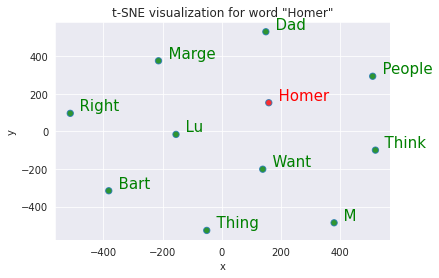

In [ ]:
tsne_plot(for_word='homer', w2v_model=w2v_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


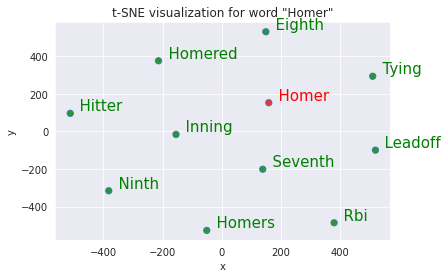

In [ ]:
tsne_plot(for_word='homer', w2v_model=vec)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


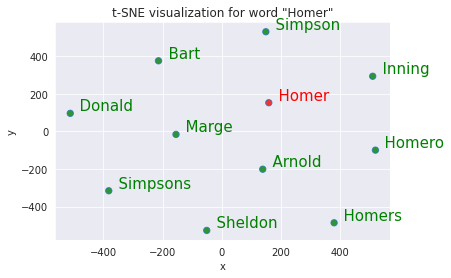

In [ ]:
tsne_plot(for_word='homer', w2v_model=vec1)